In [1]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import leastsq
import filtering
%matplotlib widget

In [2]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/FELIX/"
folder = glob(pathToData+"*")
folder

['/home/alan/Documents/LAB/CSHL/Data/FELIX/20240617 LTP with patched cell',
 '/home/alan/Documents/LAB/CSHL/Data/FELIX/20240615 extracellular recordings',
 '/home/alan/Documents/LAB/CSHL/Data/FELIX/20240614 evoked excitatory-inhibitory postsynaptic currents',
 '/home/alan/Documents/LAB/CSHL/Data/FELIX/20240617 LTP in field potential']

In [3]:
files = glob(folder[-1]+"/*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/FELIX/20240617 LTP in field potential/2024_06_17_0015.abf',
 '/home/alan/Documents/LAB/CSHL/Data/FELIX/20240617 LTP in field potential/2024_06_17_0012.abf',
 '/home/alan/Documents/LAB/CSHL/Data/FELIX/20240617 LTP in field potential/2024_06_17_0014.abf',
 '/home/alan/Documents/LAB/CSHL/Data/FELIX/20240617 LTP in field potential/2024_06_17_0016.abf',
 '/home/alan/Documents/LAB/CSHL/Data/FELIX/20240617 LTP in field potential/2024_06_17_0017.abf',
 '/home/alan/Documents/LAB/CSHL/Data/FELIX/20240617 LTP in field potential/2024_06_17_0013.abf']

In [4]:
get_protocol(files)

['LTP imnductilon',
 'ltp PP',
 'LTP imnductilon',
 'LTP imnductilon',
 'ltp PP',
 'LTP imnductilon']

In [5]:
ltp_files = files_from_protocol('PP',files)
ltp_files

['/home/alan/Documents/LAB/CSHL/Data/FELIX/20240617 LTP in field potential/2024_06_17_0012.abf',
 '/home/alan/Documents/LAB/CSHL/Data/FELIX/20240617 LTP in field potential/2024_06_17_0017.abf']

In [6]:
# LFP = ['17_0008','17_0009','17_0010','17_0011','17_0012','17_0013','17_0014']
# LFP_f = ['/home/alan/Documents/LAB/CSHL/Data/Good/20240617_LTP/2024_06_' +f+'.abf' for f in LFP] 
# WC_f = [f'/home/alan/Documents/LAB/CSHL/Data/Good/20240617_LTP/2024_06_18_000{i+7}.abf' for i in range(3)]

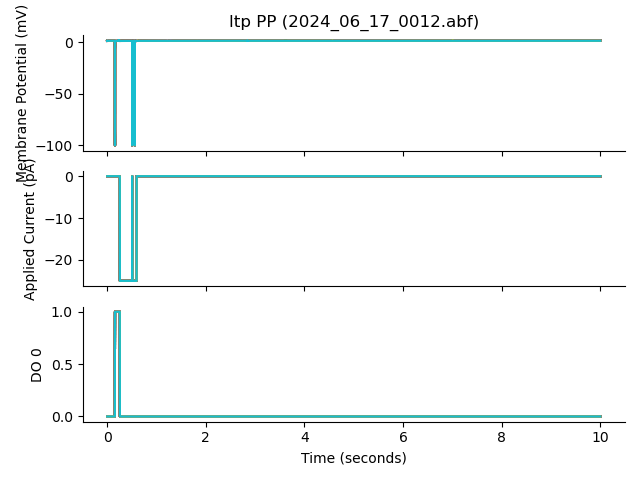

In [16]:
plt.close('all')
plot_swps_DO(ltp_files[0],[0])

In [1]:
def findstim(do,sr):
    ones = np.where(do)[1]
    stim = [ones[0]]
    on = stim[0]
    for one in ones[1:]:
        if (one-on) > 1:
            stim.append(one)
        on = one
    return np.array(stim)/sr

In [10]:
f = ltp_files[0]    
swps,DO,swp_time,sr = get_sweeps_DO(f,[1])
stims = np.array([0.5062,0.5562])
# stims = findstim(DO[0],sr)
print(stims*1e3) ## stim times in ms

[506.2 556.2]


In [20]:
# Time in seconds for components of response:
baseline = 10e-3
stim_artefact = 3e-3
AP_volley = 4e-3
EPSP =  20e-3
# for each stim extract the response
art = []
vol = []
res = []
for stim in stims:
    b = np.mean(swp_window(swps,stim-baseline,stim,sr))
    art.append(swp_window(swps,stim,stim+stim_artefact,sr) - b)
    start = stim+stim_artefact
    vol.append(swp_window(swps,start,start+AP_volley,sr) - b)
    start += AP_volley
    
    res.append(swp_window(swps,start,start+EPSP,sr))
    
artefact = np.array(art)
volley = np.array(vol)
base_vol = np.array([np.max(v,axis=1) for v in volley])
res[1] = res[1][:,:-1]
response = np.array(res) - base_vol[:,:,None]

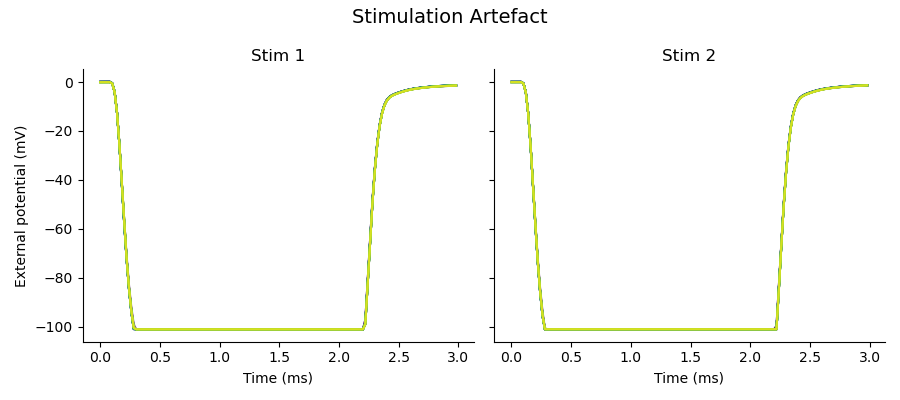

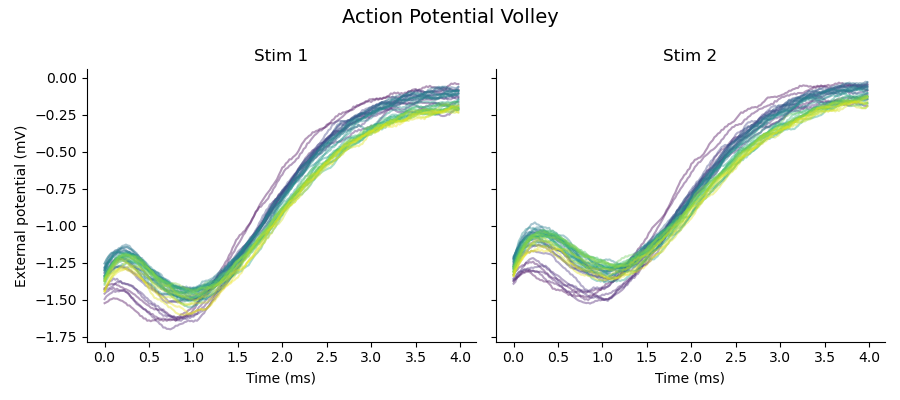

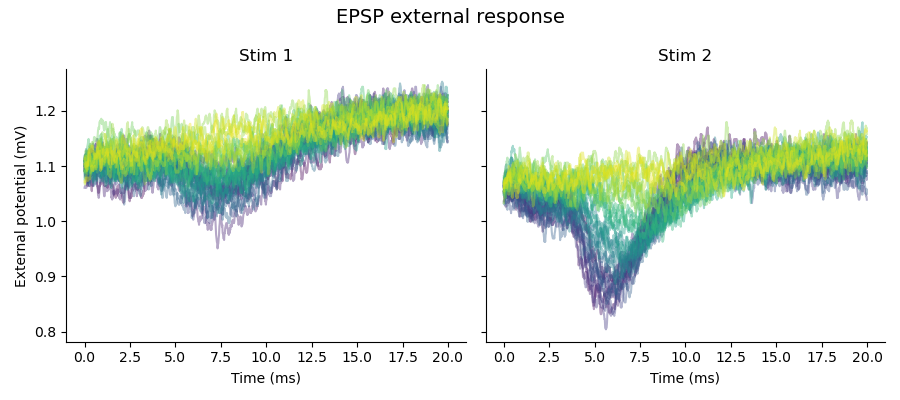

In [21]:
plt.close('all')
## Artefact
cmap = mp.colormaps['viridis']
figsize = (9,4)
fontsize = 14
alpha = 0.4
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=figsize)
fig.suptitle('Stimulation Artefact', fontsize=fontsize)
ax[0].set_ylabel('External potential (mV)')
for i,art in enumerate(artefact):
    ax[i].set_title(f'Stim {i+1}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    time = np.arange(len(art[0]))/sr
    for j,swp in enumerate(art):
        color = cmap(j/len(art))[:-1]
        ax[i].plot(time*1e3,swp,color=color,alpha=alpha)
fig.tight_layout()
## Volley
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=figsize)
fig.suptitle('Action Potential Volley', fontsize=fontsize)
ax[0].set_ylabel('External potential (mV)')
for i,vol in enumerate(volley):
    ax[i].set_title(f'Stim {i+1}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    time = np.arange(len(vol[0]))/sr
    for j,swp in enumerate(vol):
        color = cmap(j/len(vol))[:-1]
        ax[i].plot(time*1e3,swp,color=color,alpha=alpha)
fig.tight_layout()
## Response
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=figsize)
fig.suptitle('EPSP external response', fontsize=fontsize)
ax[0].set_ylabel('External potential (mV)')
for i,res in enumerate(response):
    ax[i].set_title(f'Stim {i+1}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    time = np.arange(len(res[0]))/sr
    for j,swp in enumerate(res):
        color = cmap(j/len(res))[:-1]
        ax[i].plot(time*1e3,swp,color=color,alpha=alpha)
fig.tight_layout()

In [27]:
amp_response = []
for res in response:
    amp_response.append(np.min(res,axis=1))
amp_response = np.array(amp_response)

In [28]:
ppr = amp_response[1]/amp_response[0]
# ppr = amp_response[1]/amp_response[0]
mean_ppr = np.mean(ppr)
std_ppr = np.std(ppr)
print(mean_ppr,std_ppr)

0.8919166100467179 0.05017115690602811


In [6]:
def amp_peak(f,baseline = 10e-3, stim_artefact = 3e-3,
    AP_volley = 4e-3, EPSP =  15e-3, plot=True):
    swps,DO,swp_time,sr = get_sweeps_DO(f,[0])
    stims = np.array([0.5062,0.5562])
    # for each stim extract the response
    art = []
    vol = []
    res = []
    for stim in stims:
        b = np.mean(swp_window(swps,stim-baseline,stim,sr))
        art.append(swp_window(swps,stim,stim+stim_artefact,sr) - b)
        start = stim+stim_artefact
        vol.append(swp_window(swps,start,start+AP_volley,sr) - b)
        start += AP_volley
        res.append(swp_window(swps,start,start+EPSP,sr) - b)
        
    artefact = np.array(art)
    volley = np.array(vol)
    base_vol = np.array([np.max(v,axis=1) for v in volley])
    response = np.array(res) - base_vol[:,:,None]
    ## EPSP response
    amp_response = []
    for res in response:
        amp_response.append(np.min(res,axis=1))
    amp_response = np.array(amp_response)
    if plot==True:
        cmap = mp.colormaps['viridis']
        figsize = (9,4)
        fontsize = 14
        alpha = 0.4
        fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=figsize)
        fig.suptitle('Stimulation Artefact', fontsize=fontsize)
        ax[0].set_ylabel('External potential (mV)')
        for i,art in enumerate(artefact):
            ax[i].set_title(f'Stim {i+1}')
            ax[i].set_xlabel('Time (ms)')
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['top'].set_visible(False)
            time = np.arange(len(art[0]))/sr
            for j,swp in enumerate(art):
                color = cmap(j/len(art))[:-1]
                ax[i].plot(time*1e3,swp,color=color,alpha=alpha)
        fig.tight_layout()
        ## Volley
        fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=figsize)
        fig.suptitle('Action Potential Volley', fontsize=fontsize)
        ax[0].set_ylabel('External potential (mV)')
        for i,vol in enumerate(volley):
            ax[i].set_title(f'Stim {i+1}')
            ax[i].set_xlabel('Time (ms)')
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['top'].set_visible(False)
            time = np.arange(len(vol[0]))/sr
            for j,swp in enumerate(vol):
                color = cmap(j/len(vol))[:-1]
                ax[i].plot(time*1e3,swp,color=color,alpha=alpha)
        fig.tight_layout()
        ## Response
        fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=figsize)
        fig.suptitle('EPSP external response', fontsize=fontsize)
        ax[0].set_ylabel('External potential (mV)')
        for i,res in enumerate(response):
            ax[i].set_title(f'Stim {i+1}')
            ax[i].set_xlabel('Time (ms)')
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['top'].set_visible(False)
            time = np.arange(len(res[0]))/sr
            for j,swp in enumerate(res):
                color = cmap(j/len(res))[:-1]
                ax[i].plot(time*1e3,swp,color=color,alpha=alpha)
        fig.tight_layout()
    return amp_response

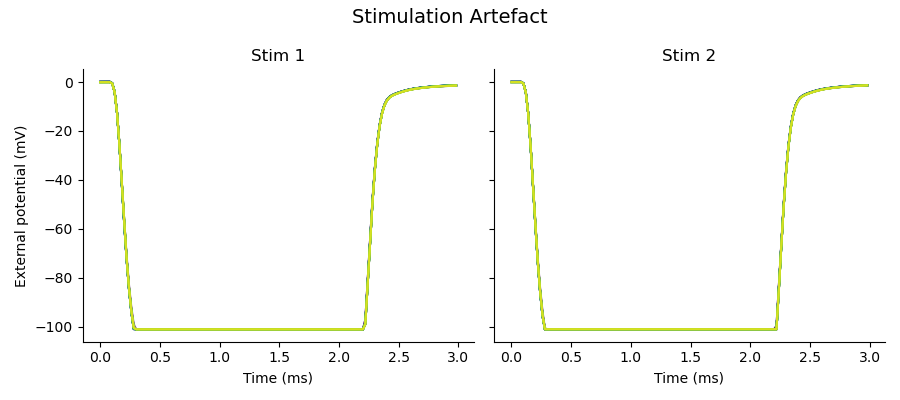

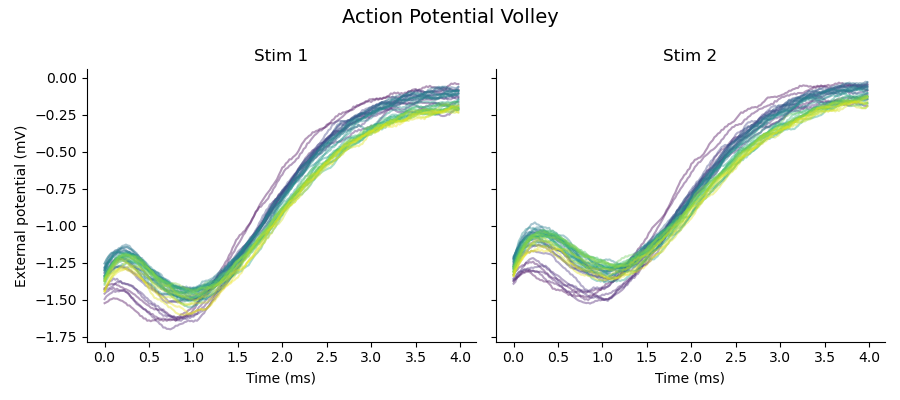

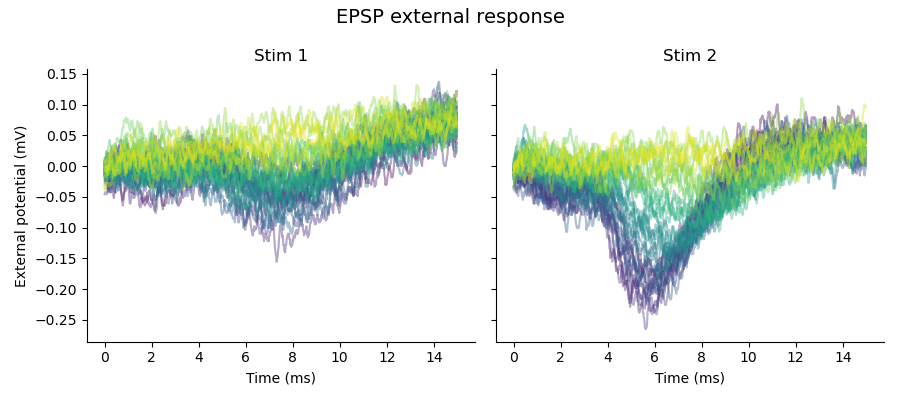

In [7]:
# plt.close('all')
# pre_files = LFP_f[:2]
# pre_amp = []
# for f in pre_files:
#     pre_amp.append(amp_peak(f,plot=True))
# pre_amp = np.array(pre_amp)
f = ltp_files[0]
plt.close('all')
pre_amp = amp_peak(f,plot=True)

In [8]:
# Stim1_pre = np.concatenate([pre_amp[0,0],pre_amp[1,0]])
# Stim2_pre = np.concatenate([pre_amp[0,1],pre_amp[1,1]])
Stim1_pre = pre_amp[0]
Stim2_pre = pre_amp[1]

In [9]:
statStim1 = [np.mean(Stim1_pre),np.std(Stim1_pre)]
statStim2 = [np.mean(Stim2_pre),np.std(Stim2_pre)]
statPpr = [np.mean(Stim2_pre/Stim1_pre),np.std(Stim2_pre/Stim1_pre)]

In [10]:
print(statStim1)
print(statStim2)
statPpr

[-0.0582122802734375, 0.03216954808738581]
[-0.1336669921875, 0.07362013892429325]


[2.3811144009088383, 0.9596242140763984]

In [11]:
f = ltp_files[1]

In [ ]:
plot_swps_DO(ltp_files[1],[0])

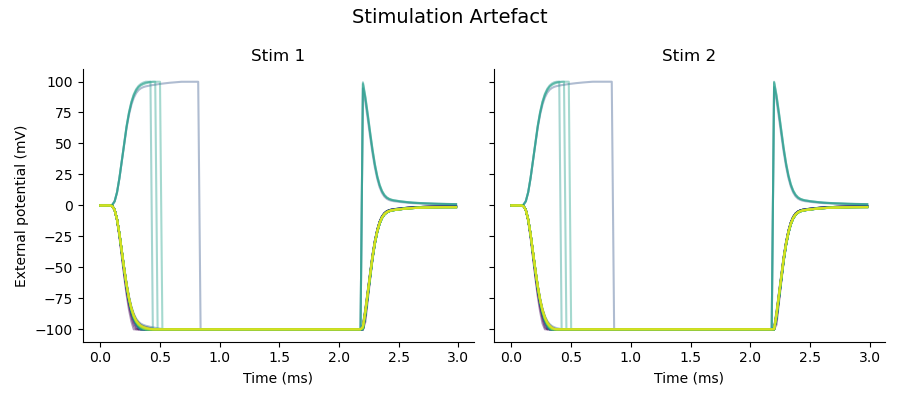

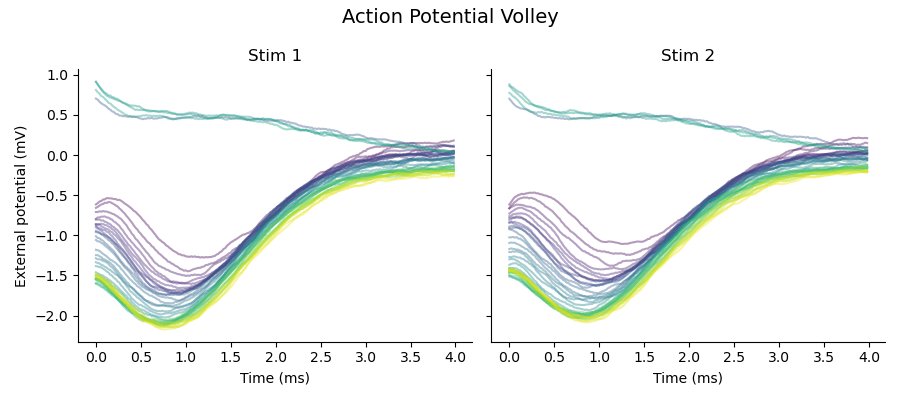

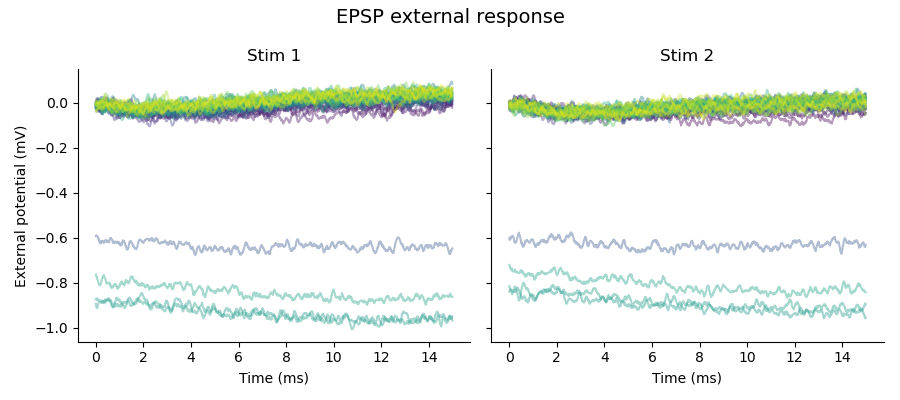

In [12]:
post_amp =amp_peak(f,plot=True)

In [13]:
# Stim1_post = np.concatenate([post_amp[0][0],post_amp[1][0]])
# Stim2_post = np.concatenate([post_amp[0][1],post_amp[1][1]])
Stim1_post = post_amp[0][post_amp[0]>-0.4]
Stim2_post = post_amp[1][post_amp[1]>-0.4]
statStim1_post = [np.mean(Stim1_post),np.std(Stim1_post)]
statStim2_post = [np.mean(Stim2_post),np.std(Stim2_post)]
statPpr_post = [np.mean(Stim2_post/Stim1_post),np.std(Stim2_post/Stim1_post)]
print(statStim1_post)
print(statStim2_post)
statPpr_post

[-0.060950385199652776, 0.017685077848590917]
[-0.07781982421875, 0.01246912706719082]


[1.3665335254695739, 0.38735237670906736]

In [14]:
print(statStim1)
print(statStim2)
statPpr

[-0.0582122802734375, 0.03216954808738581]
[-0.1336669921875, 0.07362013892429325]


[2.3811144009088383, 0.9596242140763984]

In [52]:
Stim1_norm = Stim1_post / statStim1[0]
Stim2_norm = Stim2_post / statStim2[0]

In [15]:
Stim1_post.shape

(36,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


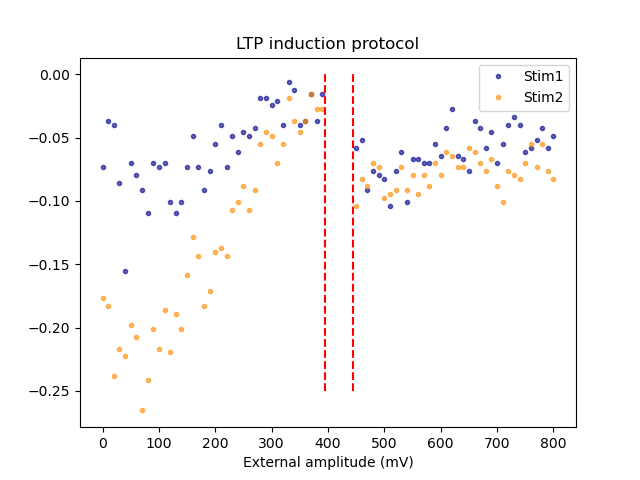

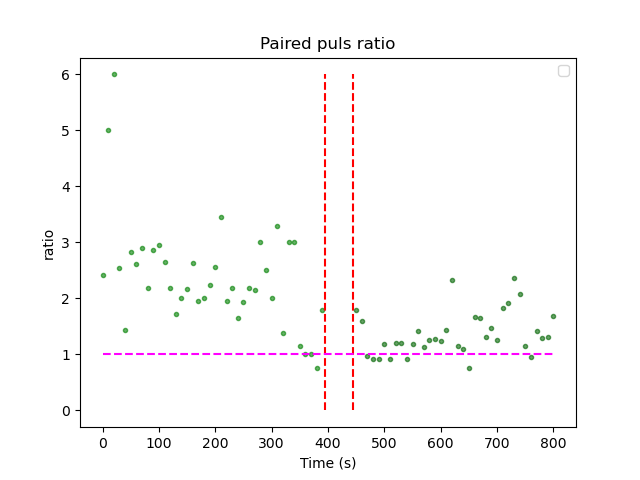

In [32]:
plt.close('all')
swp_time = 10
pre_t = np.arange(len(Stim1_pre))*10
post_t = np.arange(len(Stim1_post))*10
post_t += 450

fig,ax = plt.subplots()
ax.set_title('LTP induction protocol')
ax.plot(pre_t,Stim1_pre,'.',alpha=0.6,color='darkblue',label='Stim1')
ax.plot(pre_t,Stim2_pre,'.',alpha=0.6,color='darkorange',label='Stim2')
ax.vlines((395,445),ymin=-0.25,ymax=0,colors='red',linestyle='dashed')
ax.plot(post_t,Stim1_post,'.',alpha=0.6,color='darkblue')
ax.plot(post_t,Stim2_post,'.',alpha=0.6,color='darkorange')
ax.set_xlabel('Time (s)')
ax.set_xlabel('External amplitude (mV)')
ax.legend()

fig,ax = plt.subplots()
ax.set_title('Paired puls ratio')
ax.set_xlabel('Time (s)')
ax.set_ylabel('ratio')
ax.plot(pre_t,Stim2_pre/Stim1_pre,'.',alpha=0.6,color='green')
ax.vlines((395,445),ymin=0,ymax=6,colors='red',linestyle='dashed')
ax.plot(post_t,Stim2_post/Stim1_post,'.',alpha=0.6,color='darkgreen')
ax.hlines(1,0,800,color='fuchsia',linestyle='dashed')
ax.legend()

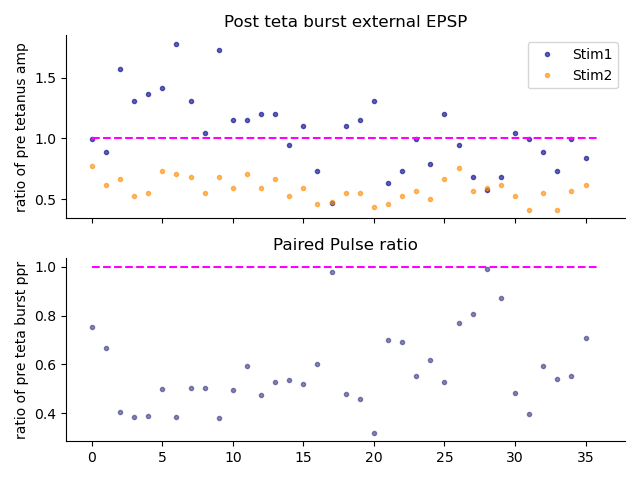

In [57]:
plt.close('all')
PPR = (Stim2_post/Stim1_post) / statPpr[0]
fig,ax = plt.subplots(2,sharex=True)
ax[0].set_title('Post teta burst external EPSP')
ax[0].set_ylabel('ratio of pre tetanus amp')
ax[0].plot(Stim1_norm,'.',alpha=0.6,color='darkblue',label='Stim1')
ax[0].plot(Stim2_norm,'.',alpha=0.6,color='darkorange',label='Stim2')
ax[0].hlines(1,0,36,color='fuchsia',linestyle='dashed')
ax[0].legend()
ax[1].set_title('Paired Pulse ratio')
ax[1].set_ylabel('ratio of pre teta burst ppr')
ax[1].plot(PPR,'.',alpha=0.5,color='midnightblue')
ax[1].hlines(1,0,36,color='fuchsia',linestyle='dashed')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
fig.tight_layout()

/tmp/ipykernel_7528/2901331152.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


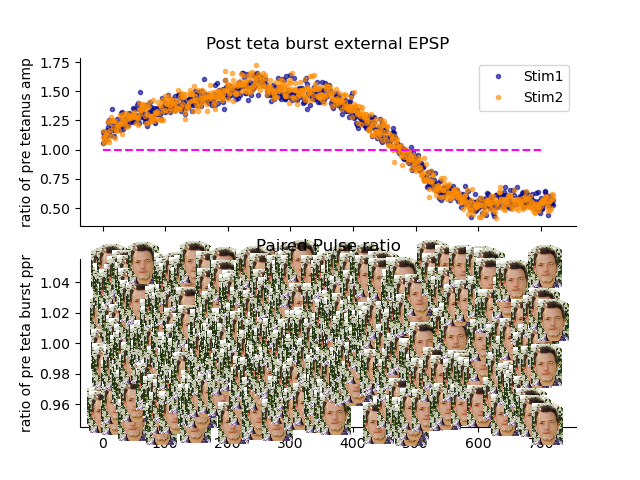

In [101]:
# the ax.plot(x,y,'line, dot,...') will plot your data to the figure
image_path = '/home/alan/Documents/LAB/CSHL/Nicolas.png'  # Path to your airplane image file
airplane_image = plt.imread(image_path)
##
# Create a custom marker using the airplane image
def airplane_marker(ax, xdata, ydata, image):
    for x, y in zip(xdata, ydata):
        ab = AnnotationBbox(OffsetImage(image, zoom=0.15), (x, y), frameon=False)
        ax.add_artist(ab)

plt.close('all')
PPR = (Stim2_post/Stim1_post) / statPpr[0]
fig,ax = plt.subplots(2,sharex=True)
ax[0].set_title('Post teta burst external EPSP')
ax[0].set_ylabel('ratio of pre tetanus amp')
ax[0].plot(Stim1_norm,'.',alpha=0.6,color='darkblue',label='Stim1')
ax[0].plot(Stim2_norm,'.',alpha=0.6,color='darkorange',label='Stim2')
ax[0].hlines(1,0,700,color='fuchsia',linestyle='dashed')
ax[0].legend()
ax[1].set_title('Paired Pulse ratio')
ax[1].set_ylabel('ratio of pre teta burst ppr')
# ax[1].plot(PPR,'.',alpha=0.5,color='midnightblue')
airplane_marker(ax[1],np.arange(len(PPR)),PPR, airplane_image)
ax[1].hlines(1,0,700,color='fuchsia',linestyle='dashed')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
fig.tight_layout()

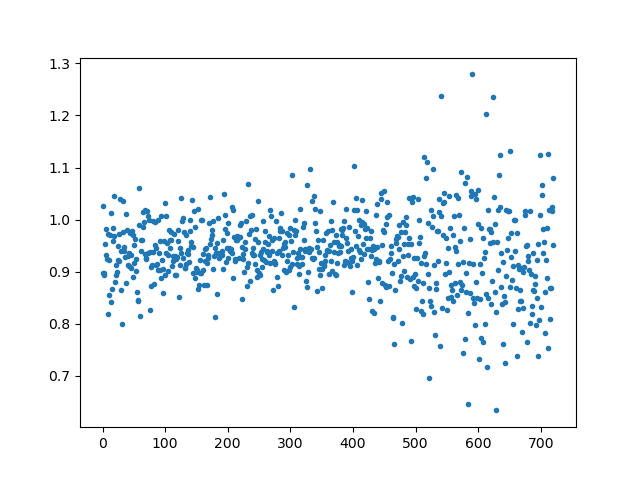

In [94]:
PPR = Stim2_post/Stim1_post
fig,ax = plt.subplots()
ax.plot(PPR,'.')

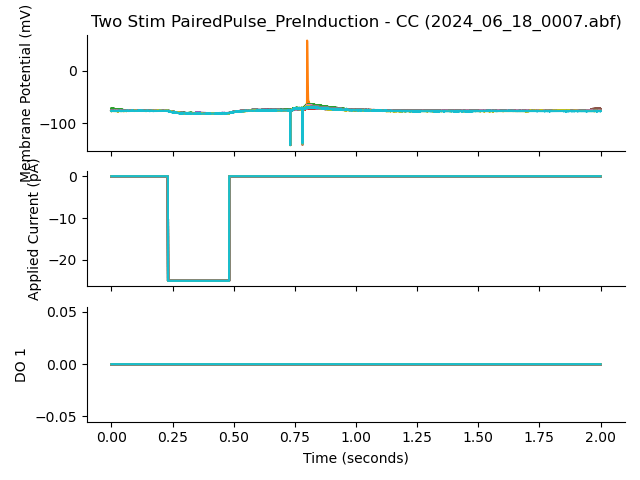

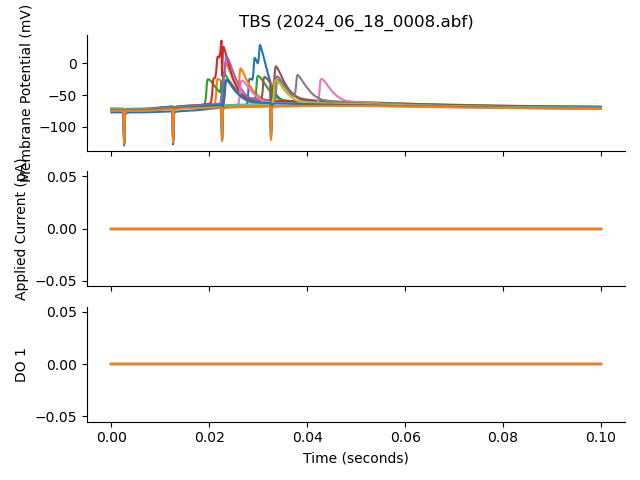

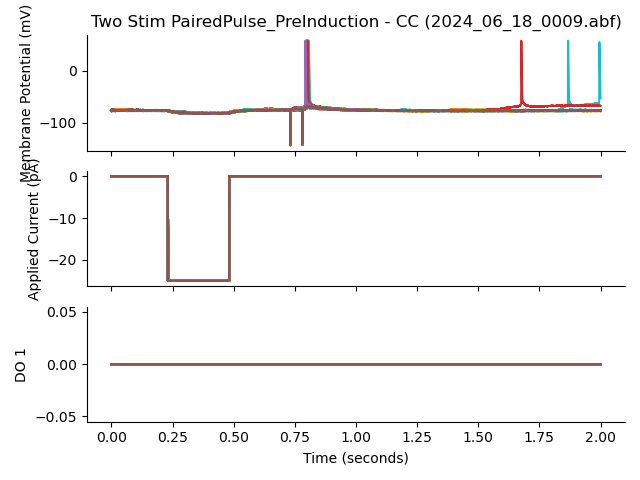

In [20]:
plt.close('all')
for f in WC_f:
    plot_swps_DO(f,[3])

In [103]:
f = WC_f[0]
swps,DO,swp_time,sr = get_sweeps_DO(f,[3])
stims = findstim(DO[0],sr)
stims

array([0.7312, 0.7813])

Spike


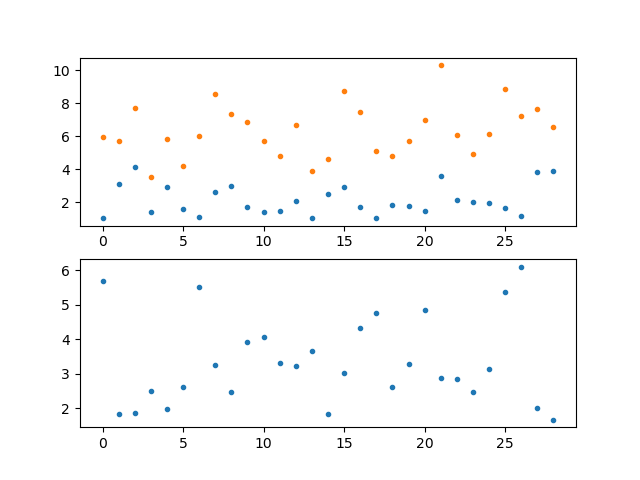

In [104]:
window = 40e-3
## Baseline voltage:
v_start = 0.7
v_end = 0.72
baseline = np.mean(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
# normalise over baseline current
stim1 = np.max(swp_window(swps,stims[0],stims[0]+window,sr,channel=0) - baseline[:,None],axis=1)
stim2 = np.max(swp_window(swps,stims[1],stims[1]+window,sr,channel=0) - baseline[:,None],axis=1)
amp = [[],[]]
for i,s1 in enumerate(stim1):
    s2 = stim2[i]
    if (s1>20) or (s2>20):
        print("Spike")
    else:
        amp[0].append(s1)
        amp[1].append(s2)
amp = np.array(amp)
ppr = amp[1]/amp[0]
fig,ax = plt.subplots(2)
ax[0].plot(amp[0],'.')
ax[0].plot(amp[1],'.')
ax[1].plot(ppr,'.')
plt.show()

In [105]:
def wc_plast(f,window = 40e-3,
             v_start = 0.7,v_end = 0.72):
    swps,DO,swp_time,sr = get_sweeps_DO(f,[3])
    stims = findstim(DO[0],sr)
    baseline = np.mean(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
    # normalise over baseline current
    stim1 = np.max(swp_window(swps,stims[0],stims[0]+window,sr,channel=0) - baseline[:,None],axis=1)
    stim2 = np.max(swp_window(swps,stims[1],stims[1]+window,sr,channel=0) - baseline[:,None],axis=1)
    amp = [[],[]]
    for i,s1 in enumerate(stim1):
        s2 = stim2[i]
        if (s1>20) or (s2>20):
            print("Spike")
        else:
            amp[0].append(s1)
            amp[1].append(s2)
    amp = np.array(amp)
    ppr = amp[1]/amp[0]
    fig,ax = plt.subplots(2)
    ax[0].plot(amp[0],'.')
    ax[0].plot(amp[1],'.')
    ax[1].plot(ppr,'.')
    plt.show()
    return amp

Spike


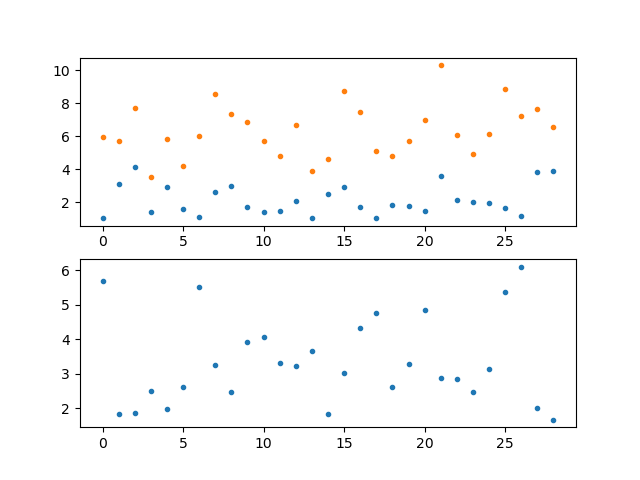

Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike
Spike


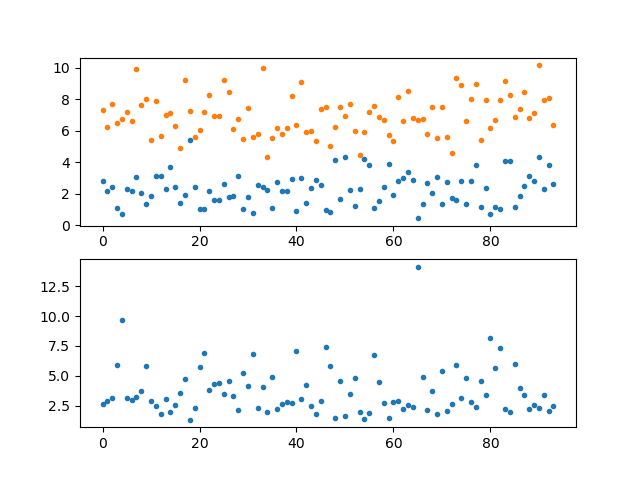

In [106]:
plt.close('all')
pre_amp = wc_plast(WC_f[0])
post_amp = wc_plast(WC_f[2])

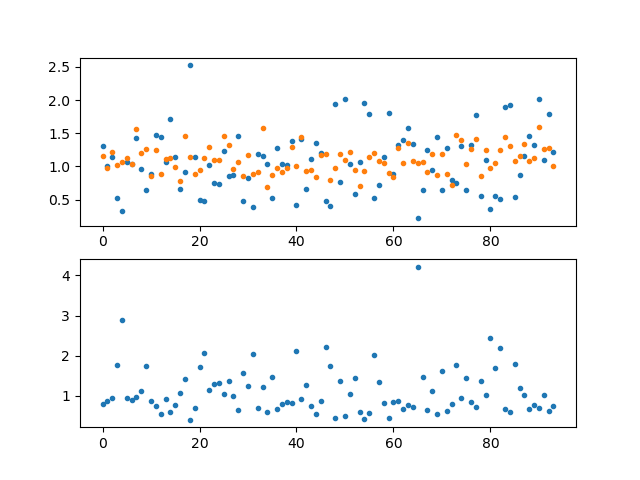

In [109]:
norm1 = post_amp[0] / np.mean(pre_amp[0])
norm2 = post_amp[1] / np.mean(pre_amp[1])
post_ppr = (post_amp[1]/post_amp[0])/ np.mean(ppr)
fig,ax = plt.subplots(2)
ax[0].plot(norm1,'.')
ax[0].plot(norm2,'.')
ax[1].plot(post_ppr,'.')
plt.show()

In [110]:
np.mean(ppr)

3.349865042293242